# Understanding mortality rates in BOP-operated prisons during 2020-2021<br>
NPR obtained a database of people who died in BOP-operated prisons in through Freedom of Information Act requests filed by NPR also requests filed by Professor Alison Guernsey at University of Iowa, shared with NPR. We compared mortality rates during bewteen 2020 and 2021 with previous years, adjusting for age. We found that mortality rates in BOP facilities in 2020 and 2021 have been higher than the five years before the pandemic.<br>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import datetime as dt
from datetime import datetime, date
from scipy import interpolate
pd.set_option('display.max_rows', 500)
pd.set_option('use_inf_as_na', True)
os.chdir('Z:/MA/20210114_prison_deaths/')
flatten = lambda t: [item for sublist in t for item in sublist]

### Importing death data
Death data preprocessing see separate notebook

In [2]:
# death data obtained through two FOIA requests
death01 = pd.read_excel('Jan2009-May2021 Deaths Analyzed.xlsx','FOIA JAN 2009 - November 2019')
death02 = pd.read_csv('20211217_2019_2021_deaths.csv')
# death data shared by Alison Guernsey at University of Iowa
death03 = pd.read_csv('20220208_BOP_deaths_Apr_21_Jan_22.csv')

In [3]:
death03 = death03.rename(columns = {'faclCode':'InstID',
                                   'BOP_RegisterNum':'RegisterNum',
                                   'actRelDate':'DOD',
                                   'age':'api_age',
                                   'sex':'api_sex',
                                   'race':'api_race'})

These deaths include privately operated facilities before 2019. We exclude them from the analysis because a) we don't have the post 2019 deaths in privately operated facilities, and b) situations in privately operated facilities are opaque, we have less on-the-ground reporting for them and don't know how similar they are to BOP-operated facilities.

In [4]:
# convert string in the date fields to date time 
def find_date(x):
    try:
        res = pd.to_datetime(x)
    except Exception:
        res = np.nan
    return res

In [5]:
#stitching the three death databases together
deathmasterraw = pd.concat([death01,death02, death03])

In [6]:
# cleaning up the columns as well as dropping duplicates - some of the requests have overlapping timeframes.
deathmaster = deathmasterraw[['InstID','RegisterNum','DOD','api_age','api_sex','api_race']].copy().drop_duplicates()
deathmaster = deathmaster.rename(columns = {'api_age':'age'})
deathmaster.DOD = [find_date(x) for x in deathmaster.DOD]
deathmaster['year'] = [x.year for x in deathmaster.DOD]
deathmaster = deathmaster.drop_duplicates()

In [7]:
deathmaster.groupby('year').RegisterNum.count()

year
2009    411
2010    402
2011    430
2012    385
2013    433
2014    493
2015    464
2016    397
2017    388
2018    383
2019    383
2020    466
2021    409
2022     17
Name: RegisterNum, dtype: int64

### Importing BOP prison population data
Sources - 
- JSON files collected by UCLA's COVID Behind Bars project
- Bureau of Prisons

#### UCLA's datasets
UCLA ran a scraper that collected json files from the BOP website.

In [8]:
jsonlist = [x for x in os.listdir('ucla_files/')]
pathlist = ['ucla_files/' + x for x in jsonlist]

In [9]:
# extract the totals and the institution codes
def parse_json(path):
    f = open(path)
    data = json.load(f)
    df = {}
    df['total_population'] = data['TOTALPOPULATION'][0]
    df['bop_population'] = data['BOPTOTAL'][0]
    df['private_population'] = data['PRIVATETOTAL'][0]
    df['date'] = data['DATEMODIFIED'][0]
    df2 = pd.DataFrame(data['BOP'])
    df2['date'] = data['DATEMODIFIED'][0]
    return df,df2

In [10]:
mainframelst = []
bopfac = []

for path in pathlist:
    try:
        df,df2 = parse_json(path)
        mainframelst.append(df)
        bopfac.append(df2)
    except Exception:
        print(path)

ucla_files/2021-07-20_federal_population.json


In [11]:
#extract population totals
mainframe = pd.DataFrame(mainframelst)
mainframe['population'] = mainframe.bop_population

In [12]:
# examine the insitution codes that have appeared each year - to see if the same set of facilities show up.
bopfacmaster = pd.DataFrame()
for df in bopfac:
     bopfacmaster = bopfacmaster.append(df)

bopfacmaster = bopfacmaster.drop_duplicates()
bopfacmaster.date = [pd.to_datetime(x) for x in bopfacmaster.date]
bopfacmaster['year'] = [x.year for x in bopfacmaster.date]

In [13]:
bopfacmaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18920 entries, 0 to 191
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   code                  18920 non-null  object        
 1   Name                  18920 non-null  object        
 2   state                 18920 non-null  object        
 3   popCount              18920 non-null  int64         
 4   groupDescription      18920 non-null  object        
 5   sortKey               18920 non-null  object        
 6   sortNameKey           18920 non-null  object        
 7   sortpzapSequence      18920 non-null  object        
 8   indentationIndicator  18920 non-null  object        
 9   recordtype            18920 non-null  object        
 10  date                  18920 non-null  datetime64[ns]
 11  year                  18920 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 1.9+ MB


In [14]:
instcnt = pd.DataFrame(bopfacmaster.groupby('year').code.unique())
instcnt['cnt'] = [len(x) for x in instcnt.code]

In [15]:
instcnt
# a facility is missing in 2022. But we aren't including them in the analysis.

,code,cnt
year,,
2016,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",122
2017,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",122
2018,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",122
2019,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",122
2020,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",122
2021,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",122
2022,"[ALD, ALI, ALF, ALM, ALP, ASH, ATL, ATW, BAS, ...",121


In [16]:
allcodes = flatten(instcnt.code)
bopcodes = list(np.unique(np.array(allcodes)))

In [17]:
len(bopcodes)
# it looks like it's the same 122 facilities throughout the years.

122

In [18]:
# using the BOP codes to filter out deaths in these facilities
deathmaster = deathmaster[deathmaster.InstID.isin(bopcodes)].copy()

In [19]:
# check if any BOP facility hasn't had any deaths
[x for x in bopcodes if x not in deathmaster.InstID.unique()]

['RBK']

#### BOP's datasets
BOP provided the population data broken down by age groups to NPR.<br>
The population totals supplement the json population count, and the age group distribution is used to calculate standardized mortality rate. BOP says these reports aren't necessarily on September 30, but a certain day in September that's close to it

In [20]:
agedist = pd.read_excel('tabula-Age_BOP_FY2015-21_cleaned.xlsx')

In [21]:
agedist.head()

,year,age,Frequency,Percent,Cumulative\rFrequency,Cumulative\rPercent
0,2021,<=19,137,0.10,137,0.10
1,2021,20 - 24,5213,3.97,5350,4.08
2,2021,25 - 29,14452,11.02,19802,15.10
3,2021,30 - 34,22029,16.79,41831,31.89
4,2021,35 - 39,23535,17.94,65366,49.83


In [22]:
# calculate population totals from the BOP dataset
reportcnt = pd.DataFrame(agedist.groupby('year').Frequency.sum())
reportcnt = reportcnt.reset_index()
reportcnt.year = reportcnt.year.astype('str')
reportcnt['date_text'] = ['09/30/' + x for x in reportcnt.year]
reportcnt['date'] = [pd.to_datetime(x) for x in reportcnt.date_text]
reportcnt = reportcnt.rename(columns = {'Frequency':'population'})

In [23]:
# calculate population percentage from raw numbers.
reportcnt1 = reportcnt[['year','population']].copy()
reportcnt1.year = reportcnt1.year.astype(int)
agedistmerge = pd.merge(agedist, reportcnt1, on = 'year', how = 'left')
agedistmerge['percent'] = agedistmerge.Frequency/agedistmerge.population
agedistmerge1 = agedistmerge[['year','age','percent']].copy()

In [24]:
# adding the BOP data to the UCLA data
popdf = pd.concat([mainframe,reportcnt])
popdf.date = [pd.to_datetime(x) for x in popdf.date]
popdf = popdf.drop_duplicates()
popdf = popdf.sort_values('date').reset_index()
popdf = popdf.drop('index', axis = 1)
popdf['year'] = [x.year for x in popdf.date]

In [25]:
popdf.tail()

,total_population,bop_population,private_population,date,population,year,date_text
100,156862.0,134447.0,6580.0,2021-12-02,134447,2021,NaN
101,156850.0,134384.0,6605.0,2021-12-09,134384,2021,NaN
102,157477.0,135033.0,6565.0,2021-12-16,135033,2021,NaN
103,157654.0,135334.0,6508.0,2021-12-30,135334,2021,NaN
104,157472.0,135380.0,6465.0,2022-01-06,135380,2022,NaN


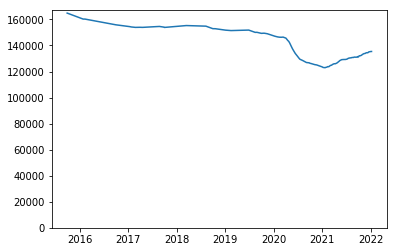

In [26]:
# check to see if the two datasets form a smooth curve. 
plt.plot(popdf.date.to_numpy(), popdf.population.to_numpy())
plt.ylim(bottom=0)
plt.show()

### Computing annualized average prison population
Given prison population decreased significantly over the course of 2020 and 2021, we calculate an annualized average population for every year using all accessible datapoints through out the year. We use linear interpolation and extrapolation to fill in the times when there's no data available.

#### Interpolate/extrapolate Jan 1 and Dec 31 values
To calculate and annualized average, we need to make sure that every year has values for the first and last day of the year. This datapoint doesn't exist for every year, so we use interpolation and extrapolation to fill in the blanks

In [27]:
def get_bookends(year):
    output = []
    yeardf = popdf[popdf.year == year]
    if year == 2015:
#         Interpolate Dec. 31
        if (yeardf.date.iloc[-1].month == 12) & (yeardf.date.iloc[-1].day == 31) == False:
            # if not, then we interpolate
            yearend = popdf[popdf.year == (year + 1)][['date','population']].iloc[0]
            yeardf = yeardf.append(yearend).sort_values('date')
            yeardf = yeardf.reset_index()
            # calculate delta of days between first date of next year and last date of this year
            delta1 = (yeardf.date.iloc[-1]-yeardf.date.iloc[-2]).days
            # calculate delta of days between Dec 31 of this year and last date of this year
            delta2 = (pd.to_datetime('12/31/' + str(year))- yeardf.date.iloc[-2]).days
            # calculate the position of Dec 31
            dec31pos = delta2/delta1
            xp = [0,1]
            fp = [yeardf.population.iloc[-2],yeardf.population.iloc[-1]]
            dec31val = np.interp(dec31pos, xp, fp)
            # append the interpolated value to yeardf
            decdict = {'date':pd.to_datetime('12/31/' + str(year)),'population':dec31val}
            output.append(decdict)
        else:
            dec31val = yeardf.population.iloc[-1]

#         extrapolate Jan1 - since we don't have data for 2014
        if (yeardf.date.iloc[0].month == 1) & (yeardf.date.iloc[0].day == 1) == False:
#             # calculate delta of days between first date of this year and last date of last year
            delta1 = (yeardf.date[0]-pd.to_datetime('01/01/' + str(year))).days
            pos1 = delta1/365
#             # calculate the position of Jan 1
            jan1pos = 0
            xp = [pos1,1] 
            fp = [yeardf.population[0],dec31val]
            f = interpolate.interp1d(xp, fp, fill_value = "extrapolate")
            jan1val = float(f(jan1pos))
            # append the interpolated value to yeardf
            jandict = {'date':pd.to_datetime('01/01/' + str(year)),'population':jan1val}
            output.append(jandict)
        else:
            pass
        
    else: # for the rest of the years, use interpolation only
        if (yeardf.date.iloc[0].month == 1) & (yeardf.date.iloc[0].day == 1) == False:
            yearend = popdf[popdf.year == (year -1)][['date','population']].iloc[-1]
            yeardf1 = yeardf.append(yearend).sort_values('date')
            yeardf1 = yeardf1.reset_index()
            # calculate delta of days between first date of this year and last date of last year
            delta1 = (yeardf1.date[1]-yeardf1.date[0]).days
            # calculate delta of days between Jan 1 of this year and last date of last year
            delta2 = (pd.to_datetime('01/01/' + str(year))- yeardf1.date[0]).days
            # calculate the position of Jan 1
            jan1pos = delta2/delta1
            xp = [0,1]
            fp = [yeardf1.population[0],yeardf1.population[1]]
            jan1val = np.interp(jan1pos, xp, fp)
            # append the interpolated value to yeardf
            jandict = {'date':pd.to_datetime('01/01/' + str(year)),'population':jan1val}
            output.append(jandict)
        else:
            pass
        if (yeardf.date.iloc[-1].month == 12) & (yeardf.date.iloc[-1].day == 31) == False:
            # if not, then we interpolate
            yearend = popdf[popdf.year == (year + 1)][['date','population']].iloc[0]
            yeardf1 = yeardf.append(yearend).sort_values('date')
            yeardf1 = yeardf1.reset_index()
            # calculate delta of days between first date of next year and last date of this year
            delta1 = (yeardf1.date.iloc[-1]-yeardf1.date.iloc[-2]).days
            # calculate delta of days between Dec 31 of this year and last date of this year
            delta2 = (pd.to_datetime('12/31/' + str(year))- yeardf1.date.iloc[-2]).days
            # calculate the position of Dec 31
            dec31pos = delta2/delta1
            xp = [0,1]
            fp = [yeardf1.population.iloc[-2],yeardf1.population.iloc[-1]]
            dec31val = np.interp(dec31pos, xp, fp)
            # append the interpolated value to yeardf
            decdict = {'date':pd.to_datetime('12/31/' + str(year)),'population':dec31val}
            output.append(decdict)
        else:
            pass

    return output

In [28]:
yearsarray = np.arange(2015,2022)

In [29]:
# compute the interpolated and extrapolated values for Jan 1 and Dec. 31 of each year
bookends = []
for year in yearsarray:
    res = get_bookends(year)
    bookends.append(res)

nbookends = flatten(bookends)
nbookendsdf = pd.DataFrame(nbookends)

In [30]:
# add the coomputed bookends to the population counts
popdf1 = pd.concat([popdf,nbookendsdf])
popdf1 = popdf1.sort_values('date')
popdf1.year = [x.year for x in popdf1.date]

#### Calcuate an average yearly population with existing data points

In [31]:
def avr_yr_pop(year):
    # extract the data points for the year
    yeardf = popdf1[popdf1.year == year][['date','population']]
    yeardf = yeardf.reset_index()
    totalarray = []
    for i,r in yeardf.iterrows():
        if i < len(yeardf)-1:
            # mean of population between two dates
            avrpop = (yeardf.population.iloc[i] + yeardf.population.iloc[i+1])/2
            # number of days between two dates
            days = (yeardf.date.iloc[i+1] - yeardf.date.iloc[i]).days
            popbydays = avrpop * days
            totalarray.append(popbydays)
        else:
            continue
    sum1 = np.sum(totalarray)
    # needed to add one day because the end date isn't included in the total count using the minus method.
    dayinyear = (yeardf.date.max() - yeardf.date.min()).days +1
    avroutput = sum1/dayinyear
    yrdict = {}
    yrdict['year'] = year
    yrdict['average_pop'] = avroutput
    return yrdict

In [32]:
avrlist = []

In [33]:
for year in list(popdf1.year.unique()):
    try:
        res= avr_yr_pop(year)
        avrlist.append(res)
    except Exception:
        continue

In [34]:
avrpopdf = pd.DataFrame(avrlist)

In [35]:
avrpopdf

,year,average_pop
0,2015,167787.783033
1,2016,157202.300688
2,2017,153773.695221
3,2018,153779.063317
4,2019,150151.090077
5,2020,134152.087237
6,2021,128770.164384
7,2022,0.000000


### Calculate standardized mortality ratio
#### Importing age percentage breakdown of prison population, provided by the BOP

In [36]:
agedist1 = pd.merge(agedistmerge1, avrpopdf, on = 'year', how = 'left' )
agedist1.columns = agedist1.columns.str.lower()
agedist1['group_pop'] = agedist1.percent * agedist1.average_pop

In [37]:
agedist1.tail()

,year,age,percent,average_pop,group_pop
106,2015,70 - 74,0.007777,167787.783033,1304.838538
107,2015,75 - 79,0.002614,167787.783033,438.678167
108,2015,80 - 84,0.000813,167787.783033,136.387179
109,2015,85 - 89,0.000158,167787.783033,26.463184
110,2015,90 - 94,0.000036,167787.783033,6.106889


In [38]:
agedist1 = agedist1.rename(columns= {'age':'age_group'})
agedist1.age_group = agedist1.age_group.str.replace('-','–')
agedist1.age_group = agedist1.age_group.str.replace(' ','')
agedist1.age_group = agedist1.age_group.str.replace('<=19','0–19')
agedist1.age_group = agedist1.age_group.str.strip()

#### Categorize age groups of each death

In [39]:
deathmaster['age_group'] = ''

In [40]:
agegroups = agedist1[['age_group']].copy().drop_duplicates()
agegroups['minage'] = [x.split('–')[0] for x in agegroups.age_group]
agegroups['maxage'] = [x.split('–')[1] for x in agegroups.age_group]
agegroups.minage = agegroups.minage.str.strip()
agegroups.minage = agegroups.minage.astype('float')
agegroups.maxage = agegroups.maxage.str.strip()
agegroups.maxage = agegroups.maxage.astype('float')

In [41]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
bins= list(agegroups.minage)
bins.append(150)
labels = list(agegroups.age_group)
deathmaster['age_group'] = pd.cut(deathmaster['age'], bins=bins, labels=labels, right=False)

In [42]:
deathmaster[deathmaster.age > 95]
# since BOP's age frequency distribution did not include people aged 95 and above, we assume that they are counted in the highest age category possible

,InstID,RegisterNum,DOD,age,api_sex,api_race,year,age_group
2970,FTW,21980-112,2015-11-26,97.0,Male,White,2015,90–94
4073,SPG,49224-079,2018-09-20,96.0,Male,White,2018,90–94
357,BUH,03366-018,2020-08-13,97.0,Male,White,2020,90–94


#### Calculate Mortality year to year
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3406211/

In [43]:
death_year_age = pd.DataFrame(deathmaster.groupby(['year','age_group']).RegisterNum.count())
death_year_age = death_year_age.reset_index()
death_year_age = death_year_age.rename(columns = {'RegisterNum':'deaths'})

In [44]:
agedist2 = pd.merge(agedist1, death_year_age, on = ['age_group','year'], how = 'left')

In [45]:
agedist2.tail()

,year,age_group,percent,average_pop,group_pop,deaths
106,2015,70–74,0.007777,167787.783033,1304.838538,35
107,2015,75–79,0.002614,167787.783033,438.678167,18
108,2015,80–84,0.000813,167787.783033,136.387179,6
109,2015,85–89,0.000158,167787.783033,26.463184,5
110,2015,90–94,0.000036,167787.783033,6.106889,1


In [46]:
# calculate death rate for each age group
agedist2['mortality_per_100k'] = agedist2.deaths/agedist2.group_pop * 100000

In [47]:
df = agedist2.pivot(index = 'age_group', columns = 'year', values = 'mortality_per_100k')

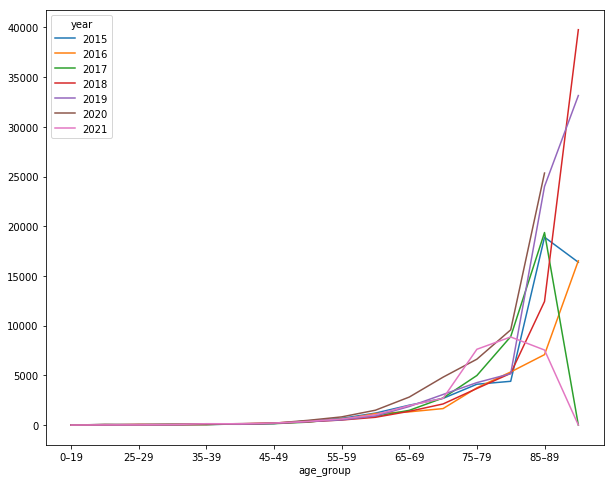

In [48]:
df.plot(figsize=(10, 8))

In [49]:
df

year,2015,2016,2017,2018,2019,2020,2021
age_group,,,,,,,
0–19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20–24,50.546471,42.521026,0.000000,15.137410,15.353898,56.876676,19.540016
25–29,25.093146,10.895638,33.111811,55.366992,22.827721,65.241396,21.144915
30–34,65.430928,49.679432,52.672781,45.184580,24.993342,49.985445,50.864004
35–39,47.606214,63.830046,48.404543,63.214593,84.594675,85.716944,134.171458
40–44,107.121674,121.501053,112.098650,110.688095,74.614300,142.833901,126.694160
45–49,148.731086,198.740914,140.076863,173.539762,163.243877,185.546447,201.569931
50–54,418.234670,373.793015,288.523761,328.707351,343.541516,468.583199,363.566003
55–59,666.803731,541.159114,646.455460,503.238922,516.957604,818.472009,615.191883


### Compare mortality rates during pandemic and five years prior
#### 2020 to 2015-2019
Using population and mortality between 2015 and 2019 as reference population.<br>
We have also considered using US population as a reference population. Similar to previous studies, we found that expected deaths exceed actual deaths when use the US population as a reference. One of the reasons can be that many causes of death in general population, like car accidents, don't exist in incarcerated environments.

In [50]:
ref = agedist2[agedist2.year < 2020].copy()

In [51]:
std = pd.DataFrame(ref.groupby('age_group').deaths.sum()/ref.groupby('age_group').group_pop.sum())
std.columns = ['expected_death_rate']

In [52]:
yr20 = agedist2[agedist2.year == 2020].copy()
yr20_1 = yr20[['age_group','group_pop','deaths']]

In [53]:
std1 = pd.merge(std, yr20_1, on = 'age_group')
std1['expected_deaths'] = std1.group_pop * std1.expected_death_rate

In [54]:
std1.deaths.sum()/std1.expected_deaths.sum()-1

0.5012510567496664

#### Compare 2021  to 2015-2019

In [55]:
yr21 = agedist2[agedist2.year == 2021].copy()
yr21_1 = yr21[['age_group','group_pop','deaths']]

In [56]:
std21 = pd.merge(std, yr21_1, on = 'age_group')
std21['expected_deaths'] = std21.group_pop * std21.expected_death_rate

In [57]:
std21.deaths.sum()/std21.expected_deaths.sum()-1

0.19888185759007215

#### Combining 2020 and 2021

In [58]:
((std21.deaths.sum() + std1.deaths.sum())/2)/((std21.expected_deaths.sum()+std1.expected_deaths.sum())/2)-1

0.3531923969916524